#Using Quantum Kernels for classifcation of cats and dogs



Installing required packages

In [ ]:
pip install pylatexenc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 9.5 MB/s eta 0:00:00


In [4]:
pip install qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512581 sha256=ece3316661d1d7b30c6adce556abf2a16da8e00245014ffcfcc63d3d94dcf263
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC
import time
from pylatexenc import *

time1 = time.time()
# Set a random seed for reproducibility
np.random.seed(1001)
###############################################################################
#Data we Will be using
###############################################################################
import tarfile
import pickle
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA

<ipython-input-5-bd4148828969>:7: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.state_fidelities import ComputeUncompute


# Classical Definitions

In [6]:
def load_cifar10_data(file_path):
    with tarfile.open(file_path, "r:gz") as tar:
        train_data = []
        Y_train = []
        for member in tar.getmembers():
            if "data_batch" in member.name:
                with tar.extractfile(member) as f:
                    data_dict = pickle.load(f, encoding="bytes")
                    train_data.append(data_dict[b"data"])
                    Y_train.extend(data_dict[b"labels"])

        train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        Y_train = np.array(Y_train)

        with tar.extractfile("cifar-10-batches-py/test_batch") as f:
            data_dict = pickle.load(f, encoding="bytes")
            X_test = data_dict[b"data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
            Y_test = np.array(data_dict[b"labels"])

    return (train_data, Y_train), (X_test, Y_test)

def preprocess_images(images, size=32):
    #images_resized = tf.image.resize(images, [size, size])
    images_normalized = images / 255.0
    #images_gray = tf.image.rgb_to_grayscale(images_normalized)
    return images_normalized

def filter_and_preprocess_data(train_images, Y_train, test_images, Y_test, num_training_points, num_testing_points, num_PCA_componants):
    cat_dog_filter_train = (Y_train == 3).flatten() | (Y_train == 5).flatten()
    cat_dog_filter_test = (Y_test == 3).flatten() | (Y_test == 5).flatten()

    X_train = train_images[cat_dog_filter_train]
    Y_train = Y_train[cat_dog_filter_train]
    X_test = test_images[cat_dog_filter_test]
    Y_test = Y_test[cat_dog_filter_test]

    # Convert labels: cat (3) -> -1, dog (5) -> 1
    Y_train = (Y_train / 5).astype(int)
    Y_train = np.where(Y_train == 0, -1, 1)
    Y_test = (Y_test / 5).astype(int)
    Y_test = np.where(Y_test == 0, -1, 1)

    # Preprocess the images
    X_train = preprocess_images(X_train)
    X_test = preprocess_images(X_test)

    # Separate cats and dogs indices
    cat_indices_train = np.where(Y_train == -1)[0]
    dog_indices_train = np.where(Y_train == 1)[0]
    cat_indices_test = np.where(Y_test == -1)[0]
    dog_indices_test = np.where(Y_test == 1)[0]

    # Randomly select equal number of cats and dogs for training and testing
    half_training = num_training_points // 2
    half_testing = num_testing_points // 2

    random_cat_train_indices = np.random.choice(cat_indices_train, half_training, replace=False)
    random_dog_train_indices = np.random.choice(dog_indices_train, half_training, replace=False)
    random_cat_test_indices = np.random.choice(cat_indices_test, half_testing, replace=False)
    random_dog_test_indices = np.random.choice(dog_indices_test, half_testing, replace=False)

    selected_train_indices = np.concatenate([random_cat_train_indices, random_dog_train_indices])
    selected_test_indices = np.concatenate([random_cat_test_indices, random_dog_test_indices])

    X_train = X_train[selected_train_indices]
    Y_train = Y_train[selected_train_indices]
    X_test = X_test[selected_test_indices]
    Y_test = Y_test[selected_test_indices]

    # Flatten and PCA
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)
    print("Number of components before PCA:", X_train_flattened.shape[1])
    pca = PCA(n_components=num_PCA_componants)
    X_train_reduced = pca.fit_transform(X_train_flattened)
    X_test_reduced = pca.transform(X_test_flattened)

    # Fit the PCA model
    pca = PCA(n_components=num_PCA_componants)
    pca.fit(X_train_flattened)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the component for each threshold
    thresholds = np.arange(0.1, 1.1, 0.1)
    components_for_thresholds = [np.argmax(cumulative_variance > threshold) for threshold in thresholds]

    # Plot the explained variance
    plt.plot(cumulative_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Components')

    # Set the x-ticks to be the component numbers
    plt.xticks(components_for_thresholds, components_for_thresholds)

    plt.grid(True)
    plt.show()
    return X_train_reduced, Y_train, X_test_reduced, Y_test

# Compute classical SVM score using reduced data
def classical_kernel(X_train_reduced, Y_train, X_test_reduced, Y_test):
    svc = SVC()
    svc.fit(X_train_reduced, Y_train)
    classical_svm_score = svc.score(X_test_reduced, Y_test)
    return classical_svm_score

#Quantum Part

In [7]:
# Define Quantum Embedding Kernel
def feature_embedding(num_features):
    '''Embed classical states onto the quantum computer'''
    # Define training parameter vector
    training_params = ParameterVector("θ", num_features)

    # Create the QuantumCircuit fm0
    fm0 = QuantumCircuit(num_features)
    for i in range(num_features):
        fm0.ry(training_params[i], i)


    # Define ZZFeatureMap
    fm1 = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement='circular')

    # Compose the feature map
    feature_map = fm0.compose(fm1)
    feature_map.draw('mpl')  # Visualize the feature map
    plt.show()
    return feature_map, training_params

# Define kernel function using FidelityQuantumKernel
def kernel(feature_map):
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    quant_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map, evaluate_duplicates='off_diagonal')
    return quant_kernel

# Perform quantum SVM classification using precomputed kernel
def quantum_svm(kernel_matrix_train, kernel_matrix_test, Y_train, Y_test):
    svc = SVC(kernel="precomputed")
    svc.fit(kernel_matrix_train, Y_train)
    score_precomputed_kernel = svc.score(kernel_matrix_test, Y_test)
    print(f"Precomputed kernel classification test score: {score_precomputed_kernel}")

# Compute Kernel-Target Alignment (KTA)
def KTA(K, y, y_outer):
    """Compute the kernel-target alignment."""
    denominator = np.sqrt(np.trace(K @ K) * np.trace(y_outer @ y_outer)) + 1e-10
    return (y.T @ K @ y) / denominator

# Compute gradient of KTA for optimization
kta_values = []
def KTA_gradient(thetas, X, Y, y_outer,delta_theta=1e-6):
    gradients = []
    for i, theta in enumerate(thetas):
        theta_shifted = np.copy(thetas)
        theta_shifted[i] += delta_theta

        bound_map_original = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
        kernel_matrix_train_original = kernel(bound_map_original).evaluate(x_vec=X)
        kta_original = KTA(kernel_matrix_train_original, Y, y_outer)

        bound_map_shifted = feature_map.bind_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})
        kernel_matrix_train_shifted = kernel(bound_map_shifted).evaluate(x_vec=X)
        kta_shifted = KTA(kernel_matrix_train_shifted, Y, y_outer)

        gradient = (kta_shifted - kta_original) / delta_theta
        gradients.append(gradient)
    print(kta_original)
    kta_values.append(kta_original)
    #print(gradients)
    return np.array(gradients)


# Plot kernel matrices for visualization
def plot_matrix(matrix_train, matrix_test, matrix_train_optimal, matrix_test_optimal):
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    axs[0, 0].imshow(
        np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
    )
    axs[0, 0].set_title("Training kernel matrix")

    axs[0, 1].imshow(
        np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds"
    )
    axs[0, 1].set_title("Testing kernel matrix")

    axs[1, 0].imshow(
        np.asmatrix(matrix_train_optimal), interpolation="nearest", origin="upper", cmap="Blues"
    )
    axs[1, 0].set_title("Optimal Training kernel matrix")

    axs[1, 1].imshow(
        np.asmatrix(matrix_test_optimal), interpolation="nearest", origin="upper", cmap="Reds"
    )
    axs[1, 1].set_title("Optimal Testing kernel matrix")

    plt.tight_layout()
    plt.show()

# Running the code

Number of components before PCA: 3072


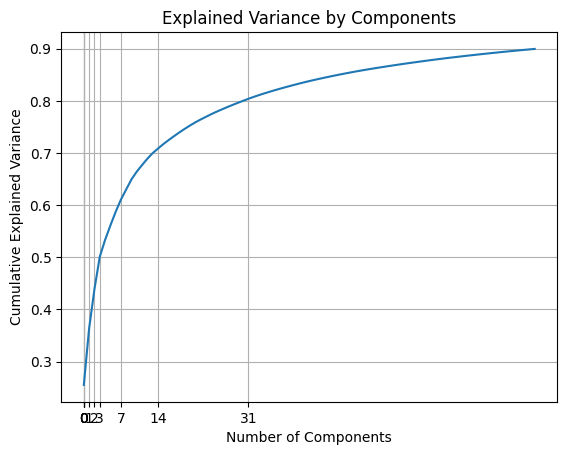

Classical kernel classification test score: 0.73


In [8]:
# Load CIFAR-10 dataset and preprocess data
file_path = r"/content/drive/MyDrive/Colab Notebooks/cifar-10-python.tar.gz" # You should adjust this to the path of your CIFAR-10 dataset tarball
(train_images, Y_train_original), (test_images, Y_test_original) = load_cifar10_data(file_path)

# Define the number of training/testing points, PCA components, and quantum circuit layers
num_training_points = 10000
num_testing_points = 100
num_features = 86

# Filter and preprocess data
X_train, Y_train, X_test, Y_test = filter_and_preprocess_data(train_images, Y_train_original, test_images, Y_test_original, num_training_points, num_testing_points, num_features)

# Test using classical SVM
classical_svm_score = classical_kernel(X_train, Y_train, X_test, Y_test)
print(f"Classical rbf kernel classification test score: {classical_svm_score}")


In [ ]:
 # Test with random (untrained) parameters
feature_map, training_params = feature_embedding(num_features)
#theta = [1.2566370614359172, 3.141592653589793, 2.5132741228718345, 0.0] #some trained params
theta = np.random.uniform(0,2*np.pi,num_features)
# Optimal theta: [5.201432097848048, 0.16795640707114898, 2.340889651896597, -0.06494248625237167]
bound_map = feature_map.bind_parameters({training_params[i]: theta[i] for i in range(num_features)})

kernel_matrix_train = kernel(bound_map).evaluate(x_vec=X_train)
kernel_matrix_test = kernel(bound_map).evaluate(x_vec=X_test, y_vec=X_train)
quantum_svm(kernel_matrix_train, kernel_matrix_test, Y_train, Y_test)

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)
<ipython-input-9-bf9e40b08d3b>:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[i]: theta[i] for i in range(num_features)})


In [ ]:
# Calculate and display the initial KTA
y_outer = np.outer(Y_train, Y_train) #can optimise becuase you only need this once
kta = KTA(kernel_matrix_train, Y_train, y_outer)
print("Initial KTA:", kta)


Initial KTA: 0.06501397108225439


In [ ]:

# Set optimization parameters
initial_learning_rate = 30
decay_rate = 1
num_iterations = 100
batch_size = 100
#theta = [3.55102703827831, 3.9451707852926354, 1.5014911517997618, 0.8790446062723056]
theta = np.random.uniform(0,2*np.pi,num_features)
kta_values = []
t1 = time.time()
# Gradient ascent optimization loop with variable learning rate
for iteration in range(num_iterations):
    # Calculate the current learning rate based on the decay schedule
    current_learning_rate = initial_learning_rate * (decay_rate ** iteration)

    # Randomly select a batch of data points
    idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
    X_batch = X_train[idx]
    Y_batch = Y_train[idx]

    # Compute the gradient using this batch
    gradient = KTA_gradient(theta, X_batch, Y_batch, y_outer)
    update = [current_learning_rate * gradient[i] for i in range(num_features)]
    # Update the parameter using the variable learning rate
    theta = [theta[i] + update[i] for i in range(num_features)]
    print(theta[0],theta[1], theta[2],theta[3])
    # Print the learning rate and iteration for monitoring
    #print(f"Iteration {iteration + 1} - Learning Rate: {current_learning_rate:.4f}")
    #print("Updated theta:", theta)



# Extract the optimal theta from the result
optimal_theta = theta
print("Optimal theta:", optimal_theta)
kta_values1 = []
t2 = time.time()
print(t2-t1, 'seconds')
# Calculate and display the maximum KTA using optimal theta
bound_map_optimal = feature_map.bind_parameters({training_params[i]: optimal_theta[i] for i in range(num_features)})
kernel_matrix_train_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_train)
kernel_matrix_test_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_test, y_vec=X_train)
quantum_svm(kernel_matrix_train_optimal, kernel_matrix_test_optimal, Y_train, Y_test)

# Plot the kernel matrices
#plot_matrix(kernel_matrix_train, kernel_matrix_test, kernel_matrix_train_optimal, kernel_matrix_test_optimal)

def KTA_gradient(thetas, X, Y, y_outer, indices_to_optimize, delta_theta=1e-6):
    gradients = np.zeros_like(thetas) # Initialize gradients array
    for i in indices_to_optimize: # Loop only over the indices you want to optimize
        theta_shifted = np.copy(thetas)
        theta_shifted[i] += delta_theta

        bound_map_original = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
        kernel_matrix_train_original = kernel(bound_map_original).evaluate(x_vec=X)
        kta_original = KTA(kernel_matrix_train_original, Y, y_outer)

        bound_map_shifted = feature_map.bind_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})
        kernel_matrix_train_shifted = kernel(bound_map_shifted).evaluate(x_vec=X)
        kta_shifted = KTA(kernel_matrix_train_shifted, Y, y_outer)

        gradient = (kta_shifted - kta_original) / delta_theta
        gradients[i] = gradient # Store gradient for this index
    kta_values1.append(kta_original)
    print(kta_original)
    return np.array(gradients)



# Set optimization parameters
initial_learning_rate = 30
decay_rate = 1
num_iterations = 100
batch_size = 100
theta = np.random.uniform(0,2*np.pi,num_features)
#theta = [3.4867625820217967, 0.8316407873036624, 0.47750437975791016, 1.1851710629562362]
#theta = [1.2566370614359172, 3.141592653589793, 2.5132741228718345, 0.0]
#theta = [5.026548245743669, 0.0, 1.8849555921538759, 0.0]
indices_to_optimize = random_indices = np.random.choice(range(len(theta)), 2, replace=False)
t3 = time.time()
# Gradient ascent optimization loop with variable learning rate
for iteration in range(num_iterations):
    # Calculate the current learning rate based on the decay schedule
    current_learning_rate = initial_learning_rate * (decay_rate ** iteration)

    # Randomly select a batch of data points
    idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
    X_batch = X_train[idx]
    Y_batch = Y_train[idx]

    # Compute the gradient using this batch
    gradient = KTA_gradient(theta, X_batch, Y_batch, y_outer, indices_to_optimize)

    # Randomly select two indices for updating


    # Update only the selected theta parameters
    for i in random_indices:
        theta[i] += current_learning_rate * gradient[i]

    indices_to_optimize = random_indices = np.random.choice(range(len(theta)), 2, replace=False)
    # You can continue with the rest of your code here, such as computing the kernel matrix, etc.

    print(theta[0],theta[1], theta[2],theta[3])


# Extract the optimal theta from the result
optimal_theta = theta
print("Optimal theta:", optimal_theta)
t4 = time.time()
print(t4-t3, 'Seconds')

# Calculate and display the maximum KTA using optimal theta
bound_map_optimal = feature_map.bind_parameters({training_params[i]: optimal_theta[i] for i in range(num_features)})
kernel_matrix_train_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_train)
kernel_matrix_test_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_test, y_vec=X_train)
quantum_svm(kernel_matrix_train_optimal, kernel_matrix_test_optimal, Y_train, Y_test)













# Measure execution time
time2 = time.time()
print("Execution time:", time2 - time1)


'''
import itertools
import pickle

num_theta_steps = 10
best_kta = 0.0
num_features = len(training_params)
best_theta = [0.0] * num_features

theta_values = []  # To store the theta values
kta_values = []    # To store the KTA values

import itertools
for steps in itertools.product(range(num_theta_steps), repeat=num_features):
    current_theta = [step * (2 * np.pi) / num_theta_steps for step in steps]
    theta_values.append(current_theta)


    # Create a binding dictionary for all the theta values
    binding_dict = {training_params[i]: current_theta[i] for i in range(num_features)}

    # Bind the current theta values to the feature map
    bound_map = feature_map.bind_parameters(binding_dict)
    kernel_matrix_train_current = kernel(bound_map).evaluate(x_vec=X_train)

    # Calculate KTA for the current theta values
    kta = KTA(kernel_matrix_train_current, Y_train, y_outer)
    kta_values.append(kta)
    # Update best theta and KTA if necessary
    if kta > best_kta:
        best_kta = kta
        best_theta = current_theta

    # Print current progress
    progress = '/'.join(map(str, steps))
    print(f"Step {progress}/{num_theta_steps} - Current KTA: {kta:.4f}")


# Saving theta and KTA values
with open('theta_values.pkl', 'wb') as f:
    pickle.dump(theta_values, f)
with open('kta_values.pkl', 'wb') as f:
    pickle.dump(kta_values, f)

# Print the best theta and corresponding KTA
print("Best Theta:", best_theta)
print("Best KTA:", best_kta)
'''

0.05473536985245178
5.692376844529107 0.5766201772292003 3.16793327306946 2.7519755463031825
0.06022215261236744
5.871667463338832 0.7329465436642337 3.5390493523951774 2.7768557725157916
0.06682618316108647
6.039618110478535 0.9007482062292596 3.8959673392275276 2.917423639861856
0.07303813603188727
6.088195580858097 1.0636970219199373 4.197312783242361 3.037936692732164
0.07694292052449289
6.054058277041025 1.208718396828731 4.413751307428874 3.122606712893934
0.07910264630068597
6.00597424903176 1.3035048850704136 4.5536664968632214 3.194927780778285
0.08008527554115459
5.965605510263312 1.3513974803766562 4.639888695827147 3.2507213522078815
0.08047908050097531
5.937111100931253 1.3732280677145017 4.6956797779979444 3.289267344022957
0.08064152111885618
5.91888319882688 1.3826737998276464 4.7344945185862555 3.3146772182276973
0.08071371235816978
5.908116655753132 1.386081804955749 4.763003439643469 3.3315065594816073
0.08074865898855936
5.902446195401862 1.3863560930479881 4.784725

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-29dd9fbecc91>", line 21, in <cell line: 11>
    gradient = KTA_gradient(theta, X_batch, Y_batch, y_outer)
  File "<ipython-input-13-95ce99371d20>", line 129, in KTA_gradient
    kernel_matrix_train_original = kernel(bound_map_original).evaluate(x_vec=X)
  File "/usr/local/lib/python3.10/dist-packages/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py", line 105, in evaluate
    kernel_matrix = self._get_symmetric_kernel_matrix(
  File "/usr/local/lib/python3.10/dist-packages/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py", line 196, in _get_symmetric_kernel_matrix
    kernel_entries = self._get_kernel_entries(left_parameters, right_parameters)
  File "/usr/local/lib/python3.10/dist-packages/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py"

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-29dd9fbecc91>", line 21, in <cell line: 11>
    gradient = KTA_gradient(theta, X_batch, Y_batch, y_outer)
  File "<ipython-input-13-95ce99371d20>", line 129, in KTA_gradient
    kernel_matrix_train_original = kernel(bound_map_original).evaluate(x_vec=X)
  File "/usr/local/lib/python3.10/dist-packages/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py", line 105, in evaluate
    kernel_matrix = self._get_symmetric_kernel_matrix(
  File "/usr/local/lib/python3.10/dist-packages/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py", line 196, in _get_symmetric_kernel_matrix
    kernel_entries = self._get_kernel_entries(left_parameters, right_parameters)
  File "/usr/local/lib/python3.10/dist-packages/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py"

TypeError: ignored

In [ ]:
pip install itertools

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [ ]:
pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import itertools
import pickle

num_theta_steps = 10
best_kta = 0.0
num_features = 4
best_theta = [0.0] * num_features

theta_values = []  # To store the theta values
kta_values = []    # To store the KTA values

import itertools
for steps in itertools.product(range(num_theta_steps), repeat=num_features):
    current_theta = [step * (2 * np.pi) / num_theta_steps for step in steps]
    theta_values.append(current_theta)


    # Create a binding dictionary for all the theta values
    binding_dict = {training_params[i]: current_theta[i] for i in range(num_features)}

    # Bind the current theta values to the feature map
    bound_map = feature_map.bind_parameters(binding_dict)
    kernel_matrix_train_current = kernel(bound_map).evaluate(x_vec=X_train)

    # Calculate KTA for the current theta values
    kta = KTA(kernel_matrix_train_current, Y_train, y_outer)
    kta_values.append(kta)
    # Update best theta and KTA if necessary
    if kta > best_kta:
        best_kta = kta
        best_theta = current_theta

    # Print current progress
    progress = '/'.join(map(str, steps))
    print(f"Step {progress}/{num_theta_steps} - Current KTA: {kta:.4f}")


# Saving theta and KTA values
with open('theta_values.pkl', 'wb') as f:
    pickle.dump(theta_values, f)
with open('kta_values.pkl', 'wb') as f:
    pickle.dump(kta_values, f)

# Print the best theta and corresponding KTA
print("Best Theta:", best_theta)
print("Best KTA:", best_kta)


NameError: ignored